Looking at how to work with the spectral extraction traces

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os

import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [3]:
import stistools

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/home/david/anaconda3/lib/python3.6/site-packages/stsci/tools/nmpfit.py:10: UserWarning: NMPFIT is deprecated - stsci.tools v 3.4.13 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.4.13 is the last version to contain it.")
/home/david/anaconda3/lib/python3.6/site-packages/stsci/tools/gfit.py:20: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


In [4]:
path = '/home/david/work/muscles/trappist-1/hst/g140m_cals/'
rawpath = path + 'all_obs/'
outpath = path + 'picked_trace_extracts/'

In [5]:
old_x1ds = glob.glob(rawpath+'*x1d.fits')

In [6]:
spectab = fits.getheader(old_x1ds[0],0)['SPTRCTAB']
spectab

'oref$q8l14504o_1dt.fits'

In [7]:
hdul = fits.open(rawpath+spectab[5:])

In [8]:
hdul.info()

Filename: /home/david/work/muscles/trappist-1/hst/g140m_cals/all_obs/q8l14504o_1dt.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     107   ()      
  1  1DT           1 BinTableHDU     59   1032R x 12C   [8A, 1I, 1I, 1I, 1024E, 1E, 1E, 1E, 1D, 1D, 67A, 67A]   


In [9]:
hdul[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                 4272 / width of table in bytes                        
NAXIS2  =                 1032                                                  
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   12                                                  
TTYPE1  = 'OPT_ELEM'           / label for field   1                            
TFORM1  = '8A      '           / data format of field: ASCII Character          
TTYPE2  = 'CENWAVE '           / label for field   2                            
TFORM2  = '1I      '           / data format of field: 2-byte INTEGER           
TUNIT2  = 'angstrom'        

In [10]:
hdul[0].header

SIMPLE  =                    T / Fits standard                                  
BITPIX  =                   16 / Bits per pixel                                 
NAXIS   =                    0 / Number of axes                                 
EXTEND  =                    T / File may contain extensions                    
ORIGIN  = 'NOAO-IRAF FITS Image Kernel July 1999' / FITS file originator        
IRAF-TLM= '19:48:23 (21/08/2006)'                                               
NEXTEND =                    1 / number of extensions in file                   
                                                                                
FILENAME= 'q8l14504o_1dt.fits' / name of file                                   
TELESCOP= 'HST     '           /                                                
INSTRUME= 'STIS    '           /                                                
DETECTOR= 'FUV-MAMA'           /                                                
DATE    = '2001-01-30T18:23:

In [11]:
data = hdul[1].data

In [12]:
data.names

['OPT_ELEM',
 'CENWAVE',
 'SPORDER',
 'NELEM',
 'A2DISPL',
 'A1CENTER',
 'A2CENTER',
 'SNR_THRESH',
 'MJD',
 'DEGPERYR',
 'PEDIGREE',
 'DESCRIP']

In [13]:
grating = fits.getheader(old_x1ds[0],0)['OPT_ELEM']
cenwave = fits.getheader(old_x1ds[0],0)['CENWAVE']
print(grating, cenwave)

G140M 1222


In [14]:
tracedata = data[(data['OPT_ELEM']==grating) & (data['CENWAVE'] == cenwave)]

In [15]:
tracedata[0]

('G140M', 1222, 1, 1024, array([-5.46, -5.44, -5.42, ...,  5.06,  5.08,  5.1 ], dtype=float32), 513.0, 36.9, 3.0, 50000.0, 0.0, 'INFLIGHT 27/02/97 30/06/98', 'Sandoval, Initial Postlaunch Calibration')

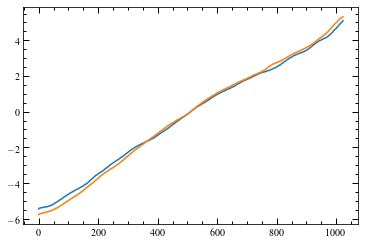

In [16]:
plt.plot(np.arange(len(tracedata[0]['A2DISPL'])),tracedata[0]['A2DISPL'] )
plt.plot(np.arange(len(tracedata[-1]['A2DISPL'])),tracedata[-1]['A2DISPL'] )

Ok...so I need to find the value of a2center at which the trace goes through my selected spectrum position.  

Build grid for all a2centers? Or ones just around the spectrum positions? How long does it take?

In [17]:
all_y = np.arange(len(tracedata[0]['A2DISPL']))
terpy = interpolate.interp1d(tracedata['A2CENTER'], tracedata['A2DISPL'], axis=0, fill_value='extrapolate')

In [18]:
tracegrid = terpy(all_y)

In [19]:
len(tracegrid[0])

1024

Ok that was quick.

In [20]:
corrgrid = [a+b for a, b in zip(tracegrid, all_y)] 
print(tracegrid[100])
print(corrgrid[100])

[-5.57009374 -5.55786111 -5.55562852 ...  4.79155728  4.80932436
  4.82320817]
[ 94.42990626  94.44213889  94.44437148 ... 104.79155728 104.80932436
 104.82320817]


In [21]:
xpick = 380
ypick = 175 

In [22]:
xcol = np.array(corrgrid)[:,xpick]
xcol

array([-1.51790162e+00, -5.18229491e-01,  4.81442641e-01, ...,
        1.01955170e+03,  1.02055227e+03,  1.02155284e+03])

In [23]:
xind = (np.abs(xcol - ypick)).argmin()
xind

177

In [24]:
all_y[xind]

177

That looks like it worked. Ok, so I need to appy that to each trace. Uhhh, need to go back and get x positions for everything as well.